In [1]:
import sys
import numpy as np
import pandas as pd
import scipy as sp
import IPython
import sklearn
from sklearn.model_selection import KFold
from sklearn.cluster import KMeans
#from sklearn.cluster import kmeans_plusplus # 0.24 版本才有

#
# Data processing
#
# import the dataset and transform it to a dataframe
df = pd.read_csv(r'D:\交大\機器學習之網路應用\lab2\dataset\raw_data.csv', error_bad_lines=False).drop_duplicates()
# Since the label in all entries of the data set is "BENIGN", there's no need for this feature
#X = df.drop(columns=['Flow.ID', 'Source.IP', 'Source.Port', 'Destination.IP', 'Timestamp', 'Label'])
X = df.filter(items=['Source.Port', 'Destination.Port', 'Protocol'])

## Swap src_port and dst_port if src_port is the smaller (well-known port)
index = -1
for src, dst in zip(X['Source.Port'], X['Destination.Port']):
    index = index +1
    if src < dst:
        # src_port = src, dst_port = dst
        X.iloc[index, 1] = src
        X.iloc[index, 0] = dst
        
#print("The 685th entry is: \n", X.iloc[685])
#print(X.head(20))

# The target cluster labels
Y_temp = pd.read_csv(r'D:\交大\機器學習之網路應用\lab2\dataset\cluster.csv', error_bad_lines=False)
Y = Y_temp['Cluster'].to_numpy()

# Drop Source.Port since we don't need it anymore
X = X.drop(columns=['Source.Port'])
# Meet the data
print(X)
print(X.columns)
print(X.shape)

# Split dataset into training_set and test_set
#kf = KFold(n_splits=2, shuffle=True, random_state=1)
#train_index = np.empty([2159, 85])
#test_index = np.empty([2158, 85])
"""
for x, y in kf.split(X):
    train_index = x
    test_index = y
    print("TRAIN:", train_index, "TEST:", test_index)
"""
#train_set = X.iloc[train_index]
#test_set = X.iloc[test_index]

      Destination.Port  Protocol
0                  443         6
1                  443         6
2                  443         6
3                  443         6
4                  443         6
...                ...       ...
4312                53        17
4313                53        17
4314                53        17
4315                53        17
4316                53        17

[4317 rows x 2 columns]
Index(['Destination.Port', 'Protocol'], dtype='object')
(4317, 2)


'\nfor x, y in kf.split(X):\n    train_index = x\n    test_index = y\n    print("TRAIN:", train_index, "TEST:", test_index)\n'

#### K-Means

In [2]:
# Do K-Means with K-means++ enabled for better initial centroids
kmeans = KMeans(n_clusters=4, init='k-means++', random_state=0)
kmeans.fit(X)
kmeans.labels_
#kmeans.predict(X.iloc[:3])

array([1, 1, 1, ..., 3, 3, 3])

In [3]:
# Evaluation
from sklearn.metrics.cluster import adjusted_mutual_info_score
print(kmeans.labels_.shape)
print(Y.shape)
adjusted_mutual_info_score(Y, kmeans.labels_)

(4317,)
(4317,)


0.9455789198780098

In [4]:
# KMeans with different parameter (init='random')
kmeans_ran = KMeans(n_clusters=4, init='random', random_state=0)
kmeans_ran.fit(X)
adjusted_mutual_info_score(Y, kmeans_ran.labels_)

0.9455789198780099

In [5]:
# KMeans with Normalization
## Normalization
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X)
X_nor = scaler.transform(X)
## Build model
kmeans_nor = KMeans(n_clusters=4, init='k-means++', random_state=0)
kmeans_nor.fit(X_nor)
adjusted_mutual_info_score(Y, kmeans_nor.labels_)

0.8494223070905361

array([[<AxesSubplot:title={'center':'Destination.Port'}>,
        <AxesSubplot:title={'center':'Protocol'}>]], dtype=object)

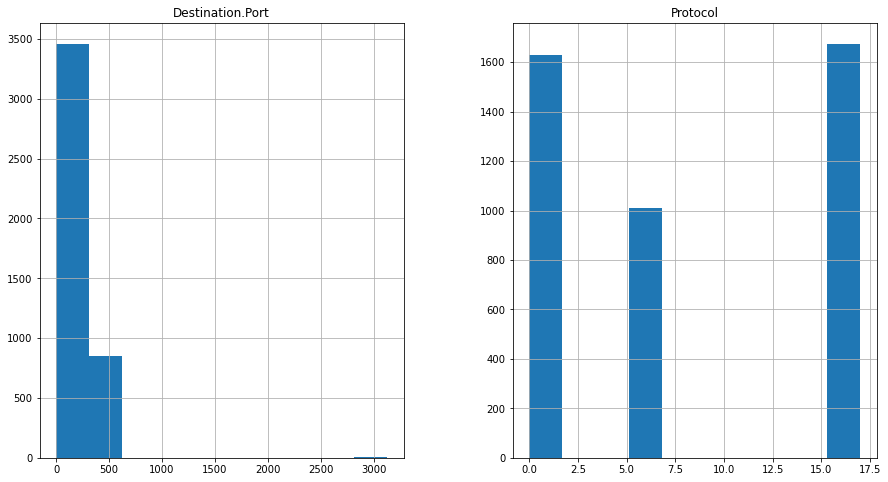

In [6]:
# Visualize the data
X.hist(figsize=(15,8))

array([[<AxesSubplot:xlabel='Destination.Port', ylabel='Destination.Port'>,
        <AxesSubplot:xlabel='Protocol', ylabel='Destination.Port'>],
       [<AxesSubplot:xlabel='Destination.Port', ylabel='Protocol'>,
        <AxesSubplot:xlabel='Protocol', ylabel='Protocol'>]], dtype=object)

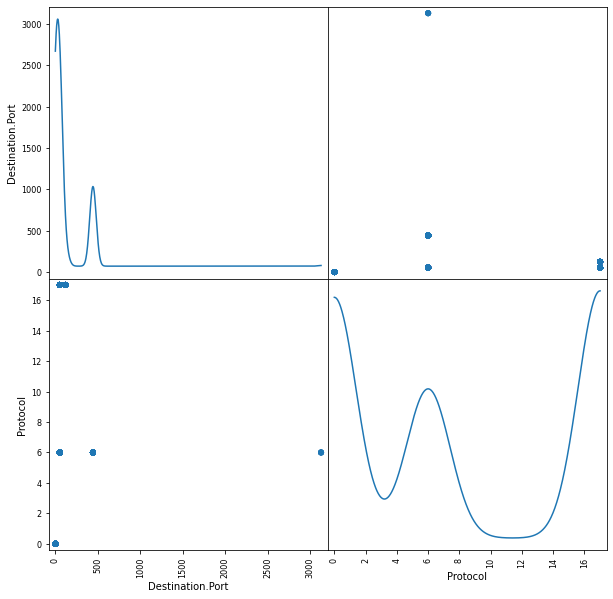

In [7]:
# Visualize the data
import matplotlib.pyplot as plt
pd.plotting.scatter_matrix(X, figsize=(10, 10),
                           diagonal='kde', marker='o', alpha=.8)

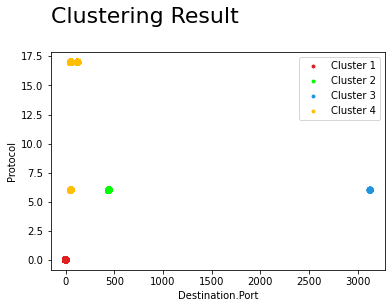

In [8]:
from matplotlib.lines import Line2D
# Visualize clusters
#X['labels'] = kmeans.fit_predict(X)
X['labels'] = kmeans.labels_
## create a color map
colors = ['#DF2020', '#00FF00', '#2095DF', '#FFBF00']
X['color'] = X.labels.map({0:colors[0], 1:colors[1], 2:colors[2], 3:colors[3]})
plt.scatter(X['Destination.Port'], X['Protocol'], c=X.color, marker='o')

# create a list of legend elemntes
## markers / records
legend_elements = [Line2D([0], [0], marker='o', color='w', label='Cluster {}'.format(i+1), 
               markerfacecolor=mcolor, markersize=5) for i, mcolor in enumerate(colors)]
# plot legend
plt.legend(handles=legend_elements, loc='upper right')
# title and labels
plt.title('Clustering Result\n', loc='left', fontsize=22)
plt.xlabel('Destination.Port')
plt.ylabel('Protocol')
# clean X
X = X.drop(columns=['labels', 'color'])

[1631, 849, 7, 1830]
[856, 135, 1631, 1695]


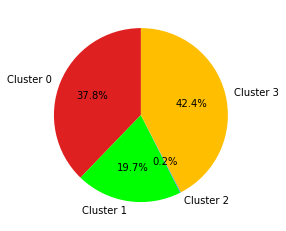

In [9]:
# Draw a pir chart for better visualization
## Get the propotions
label_samples = [sum(kmeans.labels_ == j) for j in range(4)]
print(label_samples)

# The actual propotions of Y
Y_samples = [sum(Y == j) for j in range(4)]
print(Y_samples)

clusters = ['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3']
#colors = ['r', 'g', 'y', 'blue']
colors = ['#DF2020', '#00FF00', '#2095DF', '#FFBF00']
plt.pie(label_samples, labels=clusters, colors=colors, startangle=90, autopct='%.1f%%')
plt.show()

#### Agglomerative Clustering

In [10]:
# Agglomerative Clustering (Hierarchical clustering)
from sklearn.cluster import AgglomerativeClustering
agg_linkage = AgglomerativeClustering(n_clusters=4, linkage='ward')
agg_linkage.fit(X)
agg_linkage.labels_

# Evaluation
adjusted_mutual_info_score(Y, agg_linkage.labels_)

0.9455789198780098

In [11]:
# Agglomerative Clustering with linkage="single"
agg_single = AgglomerativeClustering(n_clusters=4, linkage='single')
agg_single.fit(X)
agg_single.labels_
# Evaluation
adjusted_mutual_info_score(Y, agg_single.labels_)
# Plot Dendrogram
#from scipy.cluster.hierarchy import dendrogram

0.6984045110897034

#### DBSCAN

In [12]:
# DBSCAN with default parameters (eps=0.5, min_samples=5)
from sklearn.cluster import DBSCAN
dbscan_default = DBSCAN()
dbscan_default.fit(X)
print(dbscan_default.labels_)

# Evaluation
adjusted_mutual_info_score(Y, dbscan_default.labels_)

[0 0 0 ... 4 4 4]


0.9472274267484223

In [13]:
# DBSCAN with different parameters (eps=1, min_samples=10)
dbscan_test = DBSCAN(eps=1, min_samples=10)
dbscan_test.fit(X)
print(dbscan_test.labels_)

# Evaluation
adjusted_mutual_info_score(Y, dbscan_test.labels_)

[0 0 0 ... 3 3 3]


0.9472274267484223

[849, 135, 1631, 1540]
[856, 135, 1631, 1695]


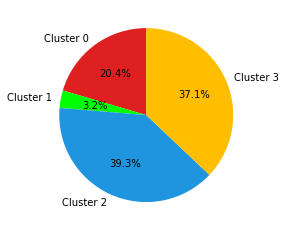

In [14]:
# Draw a pir chart for better visualization
## DBSCAN_test
## Get the propotions
label_samples = [sum(dbscan_test.labels_ == j) for j in range(4)]
print(label_samples)

# The actual propotions of Y
Y_samples = [sum(Y == j) for j in range(4)]
print(Y_samples)

clusters = ['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3']
#colors = ['r', 'g', 'y', 'blue']
colors = ['#DF2020', '#00FF00', '#2095DF', '#FFBF00']
plt.pie(label_samples, labels=clusters, colors=colors, startangle=90, autopct='%.1f%%')
plt.show()